In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import pickle
import random
import time
from copy import deepcopy

# Ensure reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

#############################################
# 1. Define the Genetic Algorithm Components
#############################################

class GeneticOptimizer:
    def __init__(self,
                 population_size=10,
                 generations=5,
                 elite_size=2,
                 mutation_rate=0.2,
                 crossover_rate=0.8,
                 search_space=None,
                 fitness_function=None):

        self.population_size = population_size
        self.generations = generations
        self.elite_size = elite_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.search_space = search_space or {
            'num_experts': [2, 3, 4, 5, 6],
            'embed_dim': [64, 128, 192, 256],
            'num_heads': [2, 4, 6, 8],
            'hidden_dim': [128, 256, 384, 512],
            'num_layers': [2, 3, 4],
            'dropout': [0.0, 0.1, 0.2, 0.3],
            'learning_rate': [0.0001, 0.0003, 0.0006, 0.001]
        }
        self.fitness_function = fitness_function
        self.population = []
        self.history = []

    def initialize_population(self):
        """Create an initial population of random individuals."""
        population = []

        for _ in range(self.population_size):
            individual = {}
            # Ensure embed_dim is divisible by num_heads
            while True:
                for param, values in self.search_space.items():
                    individual[param] = random.choice(values)
                if individual['embed_dim'] % individual['num_heads'] == 0:
                    break  # Exit loop if condition is met
            population.append({'genotype': individual, 'fitness': None})

        self.population = population
        return population

    def evaluate_population(self):
        """Evaluate the fitness of each individual in the population."""
        for i, individual in enumerate(self.population):
            if individual['fitness'] is None:
                print(f"\nEvaluating individual {i+1}/{len(self.population)}")
                print(f"Parameters: {individual['genotype']}")

                fitness = self.fitness_function(individual['genotype'])
                individual['fitness'] = fitness

                print(f"Fitness (validation loss): {fitness:.4f}")

        # Sort population by fitness (lower validation loss is better)
        self.population.sort(key=lambda x: x['fitness'])

        # Record best fitness of this generation
        best_individual = self.population[0]
        self.history.append({
            'generation': len(self.history),
            'best_fitness': best_individual['fitness'],
            'best_genotype': best_individual['genotype']
        })

        return self.population

    def select_parents(self, k=3):
        """Select parents using tournament selection."""
        parents = []

        for _ in range(2):  # Select two parents
            # Randomly select k individuals for tournament
            candidates = random.sample(self.population, k)
            # Select the best individual from the tournament
            tournament_winner = min(candidates, key=lambda x: x['fitness'])
            parents.append(deepcopy(tournament_winner))

        return parents

    def crossover(self, parent1, parent2):
        """Create a child by combining parent genotypes."""
        if random.random() > self.crossover_rate:
            # No crossover, return a copy of parent1
            return deepcopy(parent1)

        child_genotype = {}

        for param in self.search_space.keys():
            # 50% chance to inherit from each parent
            if random.random() < 0.5:
                child_genotype[param] = parent1['genotype'][param]
            else:
                child_genotype[param] = parent2['genotype'][param]

        return {'genotype': child_genotype, 'fitness': None}

    def mutate(self, individual):
        """Randomly mutate genes in an individual."""
        mutated_genotype = deepcopy(individual['genotype'])

        for param, values in self.search_space.items():
            # Apply mutation with probability mutation_rate
            if random.random() < self.mutation_rate:
                # Select a new random value different from the current one if possible
                current_value = mutated_genotype[param]
                possible_values = [v for v in values if v != current_value]

                if possible_values:
                    mutated_genotype[param] = random.choice(possible_values)

        return {'genotype': mutated_genotype, 'fitness': None}

    def create_next_generation(self):
        """Create the next generation through selection, crossover, and mutation."""
        # Preserve elite individuals
        elites = deepcopy(self.population[:self.elite_size])

        new_population = []
        new_population.extend(elites)

        # Fill the rest of the population with children
        while len(new_population) < self.population_size:
            # Select parents
            parents = self.select_parents()

            # Create child through crossover
            child = self.crossover(parents[0], parents[1])

            # Apply mutation
            child = self.mutate(child)

            new_population.append(child)

        self.population = new_population

    def run(self):
        """Run the genetic algorithm for a specified number of generations."""
        start_time = time.time()

        print("Initializing population...")
        self.initialize_population()

        for gen in range(self.generations):
            print(f"\n{'='*50}")
            print(f"Generation {gen+1}/{self.generations}")
            print(f"{'='*50}")

            # Evaluate the current population
            self.evaluate_population()

            # Print generation summary
            best_individual = self.population[0]
            print(f"\nGeneration {gen+1} complete")
            print(f"Best fitness: {best_individual['fitness']:.4f}")
            print(f"Best parameters: {best_individual['genotype']}")

            # Create the next generation (except for the last generation)
            if gen < self.generations - 1:
                self.create_next_generation()

        # Final evaluation
        best_individual = self.population[0]
        print("\nGenetic Algorithm completed!")
        print(f"Best fitness found: {best_individual['fitness']:.4f}")
        print(f"Best parameters: {best_individual['genotype']}")
        print(f"Total time: {(time.time() - start_time)/60:.2f} minutes")

        return best_individual['genotype'], self.history

#############################################
# 2. Model & Dataset Components (from existing code)
#############################################

# Reuse the TransformerExpert, GatingNetwork, and MoETransformer classes
# from the original code - just making them more flexible for hyperparameters

class TransformerExpert(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, num_layers=3, hidden_dim=256, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, 100, embed_dim))

        encoder_layers = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        embedding = self.embedding(x)
        x = embedding + self.positional_encoding[:, :x.shape[1]]
        x = self.transformer(x)
        output = self.fc(x)
        return output, embedding

class GatingNetwork(nn.Module):
    def __init__(self, embed_dim, num_experts, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, 64)
        self.fc2 = nn.Linear(64, num_experts)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.mean(dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

class MoETransformer(nn.Module):
    def __init__(self, vocab_size, num_experts=4, embed_dim=128, num_heads=4, num_layers=3, hidden_dim=256, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.experts = nn.ModuleList([
            TransformerExpert(
                vocab_size=vocab_size,
                embed_dim=embed_dim,
                num_heads=num_heads,
                num_layers=num_layers,
                hidden_dim=hidden_dim,
                dropout=dropout
            )
            for _ in range(num_experts)
        ])
        self.gating = GatingNetwork(embed_dim=embed_dim, num_experts=num_experts, dropout=dropout)

    def forward(self, x):
        expert_outputs = []
        embeddings = []

        for expert in self.experts:
            output, embedding = expert(x)
            expert_outputs.append(output)
            embeddings.append(embedding)

        stacked_outputs = torch.stack(expert_outputs, dim=-1)
        expert_weights = self.gating(embeddings[0])
        expert_weights = expert_weights.unsqueeze(1).unsqueeze(2)
        final_output = (stacked_outputs * expert_weights).sum(dim=-1)

        return final_output

# Load or create vocabulary and prepare datasets
def load_or_create_vocab(vocab_path, csv_path):
    os.makedirs(os.path.dirname(vocab_path), exist_ok=True)

    if os.path.exists(vocab_path):
        with open(vocab_path, "rb") as f:
            vocab = pickle.load(f)
    else:
        df = pd.read_csv(csv_path)
        if "tokens" not in df.columns:
            raise ValueError("CSV file must contain a 'tokens' column with tokenized sequences.")

        tokenized_equations = [row.split(" | ") for row in df["tokens"].dropna()]
        all_tokens = set(token for seq in tokenized_equations for token in seq)
        special_tokens = ["<PAD>", "<UNK>", "<EOS>"]
        vocab = {token: idx for idx, token in enumerate(special_tokens + list(all_tokens))}

        with open(vocab_path, "wb") as f:
            pickle.dump(vocab, f)

    return vocab

def prepare_data(csv_path, vocab, batch_size=32):
    df = pd.read_csv(csv_path)
    if "tokens" not in df.columns:
        raise ValueError("The CSV file must contain a 'tokens' column.")

    tokenized_equations = [row.split(" | ") for row in df["tokens"].dropna()]

    # Encode sequences
    def encode_sequence(sequence, vocab):
        return [vocab.get(token, vocab["<UNK>"]) for token in sequence] + [vocab["<EOS>"]]

    encoded_sequences = [encode_sequence(seq, vocab) for seq in tokenized_equations]

    # Prepare input-output pairs
    input_sequences = [seq[:-1] for seq in encoded_sequences]
    output_sequences = [seq[1:] for seq in encoded_sequences]

    # Pad sequences
    max_len = max(len(seq) for seq in input_sequences)
    def pad_sequence(seq, max_len, pad_token=vocab["<PAD>"]):
        return seq + [pad_token] * (max_len - len(seq))

    input_sequences = [pad_sequence(seq, max_len) for seq in input_sequences]
    output_sequences = [pad_sequence(seq, max_len) for seq in output_sequences]

    # Convert to tensors
    input_tensor = torch.tensor(input_sequences, dtype=torch.long)
    output_tensor = torch.tensor(output_sequences, dtype=torch.long)

    # Train-Test split
    indices = torch.randperm(len(input_tensor))
    split_idx = int(0.8 * len(input_tensor))
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]

    train_inputs, val_inputs = input_tensor[train_indices], input_tensor[val_indices]
    train_outputs, val_outputs = output_tensor[train_indices], output_tensor[val_indices]

    # Create datasets and data loaders
    class EquationDataset(Dataset):
        def __init__(self, inputs, outputs):
            self.inputs = inputs
            self.outputs = outputs

        def __len__(self):
            return len(self.inputs)

        def __getitem__(self, idx):
            return self.inputs[idx], self.outputs[idx]

    train_dataset = EquationDataset(train_inputs, train_outputs)
    val_dataset = EquationDataset(val_inputs, val_outputs)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, len(vocab)

#############################################
# 3. Fitness Function (Model Training & Evaluation)
#############################################

def fitness_function(params, csv_path="/content/tokenized_equations.csv", vocab_path="/mnt/data/vocab.pkl", epochs=10):
    """Train and evaluate model with given hyperparameters and return validation loss."""
    # Extract hyperparameters
    num_experts = params['num_experts']
    embed_dim = params['embed_dim']
    num_heads = params['num_heads']
    hidden_dim = params['hidden_dim']
    num_layers = params['num_layers']
    dropout = params['dropout']
    learning_rate = params['learning_rate']

    # Load vocabulary and prepare data
    vocab = load_or_create_vocab(vocab_path, csv_path)
    train_loader, val_loader, vocab_size = prepare_data(csv_path, vocab, batch_size=32)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model
    model = MoETransformer(
        vocab_size=vocab_size,
        num_experts=num_experts,
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        dropout=dropout
    ).to(device)

    # Setup training
    criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # Training loop
    best_val_loss = float('inf')
    patience = 3
    counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.permute(0, 2, 1)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                outputs = outputs.permute(0, 2, 1)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Update learning rate
        scheduler.step(avg_val_loss)

        # Print metrics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    return best_val_loss

#############################################
# 4. Run Genetic Algorithm Optimization
#############################################

def main(csv_path="/content/tokenized_equations.csv", vocab_path="/mnt/data/vocab.pkl"):
    # Define fitness function with fixed file paths
    def wrapped_fitness(params):
        return fitness_function(params, csv_path=csv_path, vocab_path=vocab_path, epochs=5)

    # Create genetic optimizer
    optimizer = GeneticOptimizer(
        population_size=8,
        generations=3,
        elite_size=2,
        mutation_rate=0.2,
        crossover_rate=0.8,
        fitness_function=wrapped_fitness
    )

    # Run optimization
    best_params, history = optimizer.run()

    # Train final model with best parameters
    print("\nTraining final model with best parameters...")
    final_model_fitness = fitness_function(best_params, csv_path=csv_path, vocab_path=vocab_path, epochs=20)
    print(f"Final model validation loss: {final_model_fitness:.4f}")

    # Save best hyperparameters
    best_params['final_val_loss'] = final_model_fitness
    with open("/mnt/data/best_hyperparameters.pkl", "wb") as f:
        pickle.dump(best_params, f)

    print(f"Best hyperparameters saved to /mnt/data/best_hyperparameters.pkl")

    return best_params, history

if __name__ == "__main__":
    # Run the genetic algorithm optimization
    best_params, history = main(
        csv_path="/content/tokenized_equations.csv",
        vocab_path="/mnt/data/vocab.pkl"
    )

    # Print optimization results
    print("\nGenetic Algorithm Optimization Results:")
    print("======================================")
    print(f"Best parameters found: {best_params}")
    print("\nOptimization history:")
    for gen in history:
        print(f"Generation {gen['generation']}: Best fitness = {gen['best_fitness']:.4f}")

Initializing population...

Generation 1/3

Evaluating individual 1/8
Parameters: {'num_experts': 6, 'embed_dim': 64, 'num_heads': 8, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.0, 'learning_rate': 0.0003}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.6397, Val Loss: 4.5289
Epoch 2/5, Train Loss: 4.4855, Val Loss: 4.3774
Epoch 3/5, Train Loss: 4.3323, Val Loss: 4.2324
Epoch 4/5, Train Loss: 4.1871, Val Loss: 4.0941
Epoch 5/5, Train Loss: 4.0591, Val Loss: 3.9645
Fitness (validation loss): 3.9645

Evaluating individual 2/8
Parameters: {'num_experts': 3, 'embed_dim': 64, 'num_heads': 4, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.3, 'learning_rate': 0.0006}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.6335, Val Loss: 4.2428
Epoch 2/5, Train Loss: 4.1265, Val Loss: 3.8534
Epoch 3/5, Train Loss: 3.8259, Val Loss: 3.6051
Epoch 4/5, Train Loss: 3.6282, Val Loss: 3.4374
Epoch 5/5, Train Loss: 3.4972, Val Loss: 3.3095
Fitness (validation loss): 3.3095

Evaluating individual 3/8
Parameters: {'num_experts': 2, 'embed_dim': 128, 'num_heads': 8, 'hidden_dim': 384, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0003}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.5847, Val Loss: 4.1616
Epoch 2/5, Train Loss: 4.0357, Val Loss: 3.7267
Epoch 3/5, Train Loss: 3.6712, Val Loss: 3.4471
Epoch 4/5, Train Loss: 3.4645, Val Loss: 3.2536
Epoch 5/5, Train Loss: 3.2977, Val Loss: 3.1085
Fitness (validation loss): 3.1085

Evaluating individual 4/8
Parameters: {'num_experts': 4, 'embed_dim': 64, 'num_heads': 2, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.0006}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.6174, Val Loss: 4.2403
Epoch 2/5, Train Loss: 4.0763, Val Loss: 3.8574
Epoch 3/5, Train Loss: 3.7443, Val Loss: 3.6270
Epoch 4/5, Train Loss: 3.5309, Val Loss: 3.4677
Epoch 5/5, Train Loss: 3.4034, Val Loss: 3.3494
Fitness (validation loss): 3.3494

Evaluating individual 5/8
Parameters: {'num_experts': 6, 'embed_dim': 192, 'num_heads': 2, 'hidden_dim': 512, 'num_layers': 4, 'dropout': 0.0, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 3.8772, Val Loss: 3.2211
Epoch 2/5, Train Loss: 2.9785, Val Loss: 2.8078
Epoch 3/5, Train Loss: 2.5058, Val Loss: 2.5018
Epoch 4/5, Train Loss: 2.1994, Val Loss: 2.2879
Epoch 5/5, Train Loss: 1.9320, Val Loss: 2.1461
Fitness (validation loss): 2.1461

Evaluating individual 6/8
Parameters: {'num_experts': 2, 'embed_dim': 192, 'num_heads': 6, 'hidden_dim': 256, 'num_layers': 4, 'dropout': 0.0, 'learning_rate': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.6722, Val Loss: 4.4230
Epoch 2/5, Train Loss: 4.2988, Val Loss: 4.1044
Epoch 3/5, Train Loss: 3.9899, Val Loss: 3.8516
Epoch 4/5, Train Loss: 3.7400, Val Loss: 3.6612
Epoch 5/5, Train Loss: 3.5694, Val Loss: 3.5185
Fitness (validation loss): 3.5185

Evaluating individual 7/8
Parameters: {'num_experts': 3, 'embed_dim': 192, 'num_heads': 2, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'learning_rate': 0.0006}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.4005, Val Loss: 3.8238
Epoch 2/5, Train Loss: 3.5713, Val Loss: 3.2757
Epoch 3/5, Train Loss: 3.1513, Val Loss: 2.9983
Epoch 4/5, Train Loss: 2.8838, Val Loss: 2.8103
Epoch 5/5, Train Loss: 2.7550, Val Loss: 2.6363
Fitness (validation loss): 2.6363

Evaluating individual 8/8
Parameters: {'num_experts': 5, 'embed_dim': 192, 'num_heads': 4, 'hidden_dim': 384, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0006}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.1958, Val Loss: 3.4125
Epoch 2/5, Train Loss: 3.2415, Val Loss: 3.0716
Epoch 3/5, Train Loss: 2.9490, Val Loss: 2.8527
Epoch 4/5, Train Loss: 2.7457, Val Loss: 2.6500
Epoch 5/5, Train Loss: 2.4820, Val Loss: 2.5089
Fitness (validation loss): 2.5089

Generation 1 complete
Best fitness: 2.1461
Best parameters: {'num_experts': 6, 'embed_dim': 192, 'num_heads': 2, 'hidden_dim': 512, 'num_layers': 4, 'dropout': 0.0, 'learning_rate': 0.001}

Generation 2/3

Evaluating individual 3/8
Parameters: {'num_experts': 2, 'embed_dim': 192, 'num_heads': 2, 'hidden_dim': 512, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0006}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.2492, Val Loss: 3.4069
Epoch 2/5, Train Loss: 3.3038, Val Loss: 3.0609
Epoch 3/5, Train Loss: 2.9773, Val Loss: 2.8168
Epoch 4/5, Train Loss: 2.6675, Val Loss: 2.5577
Epoch 5/5, Train Loss: 2.3876, Val Loss: 2.3927
Fitness (validation loss): 2.3927

Evaluating individual 4/8
Parameters: {'num_experts': 5, 'embed_dim': 64, 'num_heads': 4, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0003}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.7223, Val Loss: 4.5321
Epoch 2/5, Train Loss: 4.5066, Val Loss: 4.3106
Epoch 3/5, Train Loss: 4.2969, Val Loss: 4.1184
Epoch 4/5, Train Loss: 4.1073, Val Loss: 3.9569
Epoch 5/5, Train Loss: 3.9727, Val Loss: 3.8217
Fitness (validation loss): 3.8217

Evaluating individual 5/8
Parameters: {'num_experts': 6, 'embed_dim': 192, 'num_heads': 2, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.0006}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.3968, Val Loss: 3.7618
Epoch 2/5, Train Loss: 3.5315, Val Loss: 3.2499
Epoch 3/5, Train Loss: 3.1325, Val Loss: 3.0364
Epoch 4/5, Train Loss: 2.9380, Val Loss: 2.8778
Epoch 5/5, Train Loss: 2.7330, Val Loss: 2.6843
Fitness (validation loss): 2.6843

Evaluating individual 6/8
Parameters: {'num_experts': 5, 'embed_dim': 192, 'num_heads': 6, 'hidden_dim': 384, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.0521, Val Loss: 3.1668
Epoch 2/5, Train Loss: 3.0279, Val Loss: 2.8600
Epoch 3/5, Train Loss: 2.6620, Val Loss: 2.4775
Epoch 4/5, Train Loss: 2.2904, Val Loss: 2.2356
Epoch 5/5, Train Loss: 2.0228, Val Loss: 2.0784
Fitness (validation loss): 2.0784

Evaluating individual 7/8
Parameters: {'num_experts': 6, 'embed_dim': 256, 'num_heads': 2, 'hidden_dim': 512, 'num_layers': 4, 'dropout': 0.0, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 3.8390, Val Loss: 3.0530
Epoch 2/5, Train Loss: 2.8373, Val Loss: 2.5906
Epoch 3/5, Train Loss: 2.2989, Val Loss: 2.3410
Epoch 4/5, Train Loss: 1.9197, Val Loss: 2.1165
Epoch 5/5, Train Loss: 1.6146, Val Loss: 1.9695
Fitness (validation loss): 1.9695

Evaluating individual 8/8
Parameters: {'num_experts': 3, 'embed_dim': 128, 'num_heads': 8, 'hidden_dim': 384, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0003}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.5380, Val Loss: 4.1199
Epoch 2/5, Train Loss: 3.9517, Val Loss: 3.6876
Epoch 3/5, Train Loss: 3.5950, Val Loss: 3.4413
Epoch 4/5, Train Loss: 3.4178, Val Loss: 3.2890
Epoch 5/5, Train Loss: 3.2350, Val Loss: 3.1741
Fitness (validation loss): 3.1741

Generation 2 complete
Best fitness: 1.9695
Best parameters: {'num_experts': 6, 'embed_dim': 256, 'num_heads': 2, 'hidden_dim': 512, 'num_layers': 4, 'dropout': 0.0, 'learning_rate': 0.001}

Generation 3/3

Evaluating individual 3/8
Parameters: {'num_experts': 6, 'embed_dim': 192, 'num_heads': 2, 'hidden_dim': 384, 'num_layers': 2, 'dropout': 0.3, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.1261, Val Loss: 3.3064
Epoch 2/5, Train Loss: 3.1465, Val Loss: 2.9668
Epoch 3/5, Train Loss: 2.7777, Val Loss: 2.7324
Epoch 4/5, Train Loss: 2.4325, Val Loss: 2.5491
Epoch 5/5, Train Loss: 2.2517, Val Loss: 2.4240
Fitness (validation loss): 2.4240

Evaluating individual 4/8
Parameters: {'num_experts': 5, 'embed_dim': 192, 'num_heads': 4, 'hidden_dim': 384, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 4.0610, Val Loss: 3.1750
Epoch 2/5, Train Loss: 3.0917, Val Loss: 2.8787
Epoch 3/5, Train Loss: 2.7665, Val Loss: 2.5311
Epoch 4/5, Train Loss: 2.4217, Val Loss: 2.3094
Epoch 5/5, Train Loss: 2.1576, Val Loss: 2.1008
Fitness (validation loss): 2.1008

Evaluating individual 5/8
Parameters: {'num_experts': 4, 'embed_dim': 256, 'num_heads': 8, 'hidden_dim': 512, 'num_layers': 4, 'dropout': 0.3, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 3.8699, Val Loss: 3.0553
Epoch 2/5, Train Loss: 3.0676, Val Loss: 2.7023
Epoch 3/5, Train Loss: 2.5653, Val Loss: 2.3548
Epoch 4/5, Train Loss: 2.1956, Val Loss: 2.1053
Epoch 5/5, Train Loss: 1.9693, Val Loss: 1.9726
Fitness (validation loss): 1.9726

Evaluating individual 6/8
Parameters: {'num_experts': 4, 'embed_dim': 192, 'num_heads': 2, 'hidden_dim': 384, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 3.9658, Val Loss: 3.1793
Epoch 2/5, Train Loss: 3.0636, Val Loss: 2.8995
Epoch 3/5, Train Loss: 2.7293, Val Loss: 2.5411
Epoch 4/5, Train Loss: 2.3475, Val Loss: 2.3210
Epoch 5/5, Train Loss: 2.0888, Val Loss: 2.1607
Fitness (validation loss): 2.1607

Evaluating individual 7/8
Parameters: {'num_experts': 6, 'embed_dim': 192, 'num_heads': 2, 'hidden_dim': 512, 'num_layers': 4, 'dropout': 0.0, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 3.7773, Val Loss: 3.1744
Epoch 2/5, Train Loss: 2.8910, Val Loss: 2.8202
Epoch 3/5, Train Loss: 2.4521, Val Loss: 2.5377
Epoch 4/5, Train Loss: 2.0530, Val Loss: 2.3448
Epoch 5/5, Train Loss: 1.7872, Val Loss: 2.2684
Fitness (validation loss): 2.2684

Evaluating individual 8/8
Parameters: {'num_experts': 2, 'embed_dim': 256, 'num_heads': 2, 'hidden_dim': 256, 'num_layers': 4, 'dropout': 0.0, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 3.8930, Val Loss: 3.1522
Epoch 2/5, Train Loss: 3.0109, Val Loss: 2.7544
Epoch 3/5, Train Loss: 2.5377, Val Loss: 2.4032
Epoch 4/5, Train Loss: 2.1513, Val Loss: 2.1767
Epoch 5/5, Train Loss: 1.8268, Val Loss: 2.0565
Fitness (validation loss): 2.0565

Generation 3 complete
Best fitness: 1.9695
Best parameters: {'num_experts': 6, 'embed_dim': 256, 'num_heads': 2, 'hidden_dim': 512, 'num_layers': 4, 'dropout': 0.0, 'learning_rate': 0.001}

Genetic Algorithm completed!
Best fitness found: 1.9695
Best parameters: {'num_experts': 6, 'embed_dim': 256, 'num_heads': 2, 'hidden_dim': 512, 'num_layers': 4, 'dropout': 0.0, 'learning_rate': 0.001}
Total time: 4.78 minutes

Training final model with best parameters...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20, Train Loss: 3.7646, Val Loss: 3.0882
Epoch 2/20, Train Loss: 2.8213, Val Loss: 2.6107
Epoch 3/20, Train Loss: 2.3168, Val Loss: 2.2514
Epoch 4/20, Train Loss: 1.9220, Val Loss: 2.0462
Epoch 5/20, Train Loss: 1.6215, Val Loss: 1.9043
Epoch 6/20, Train Loss: 1.3662, Val Loss: 1.8147
Epoch 7/20, Train Loss: 1.1028, Val Loss: 1.7191
Epoch 8/20, Train Loss: 0.8617, Val Loss: 1.5988
Epoch 9/20, Train Loss: 0.6428, Val Loss: 1.4404
Epoch 10/20, Train Loss: 0.4691, Val Loss: 1.3006
Epoch 11/20, Train Loss: 0.3120, Val Loss: 1.1572
Epoch 12/20, Train Loss: 0.2135, Val Loss: 1.0706
Epoch 13/20, Train Loss: 0.1362, Val Loss: 0.9685
Epoch 14/20, Train Loss: 0.0812, Val Loss: 0.8958
Epoch 15/20, Train Loss: 0.0523, Val Loss: 0.8228
Epoch 16/20, Train Loss: 0.0306, Val Loss: 0.7763
Epoch 17/20, Train Loss: 0.0229, Val Loss: 0.7477
Epoch 18/20, Train Loss: 0.0152, Val Loss: 0.7551
Epoch 19/20, Train Loss: 0.0113, Val Loss: 0.7569
Epoch 20/20, Train Loss: 0.0072, Val Loss: 0.7631
Early sto

# **TESTING**

Best hyperparameters loaded successfully.
Best parameters: {'num_experts': 6, 'embed_dim': 256, 'num_heads': 2, 'hidden_dim': 512, 'num_layers': 4, 'dropout': 0.0, 'learning_rate': 0.001, 'final_val_loss': 0.7477479577064514}
Vocabulary loaded with 112 tokens
Dataset loaded with 100 samples

--- Training Model with Best Hyperparameters ---
Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20, Train Loss: 3.9256, Val Loss: 3.0706, Val Accuracy: 29.31%
Model saved at epoch 1 with validation loss: 3.0706
Epoch 2/20, Train Loss: 2.8838, Val Loss: 2.6530, Val Accuracy: 38.97%
Model saved at epoch 2 with validation loss: 2.6530
Epoch 3/20, Train Loss: 2.3780, Val Loss: 2.2396, Val Accuracy: 43.79%
Model saved at epoch 3 with validation loss: 2.2396
Epoch 4/20, Train Loss: 2.0036, Val Loss: 2.0235, Val Accuracy: 50.69%
Model saved at epoch 4 with validation loss: 2.0235
Epoch 5/20, Train Loss: 1.7250, Val Loss: 1.8250, Val Accuracy: 51.38%
Model saved at epoch 5 with validation loss: 1.8250
Epoch 6/20, Train Loss: 1.4049, Val Loss: 1.6711, Val Accuracy: 56.90%
Model saved at epoch 6 with validation loss: 1.6711
Epoch 7/20, Train Loss: 1.1660, Val Loss: 1.5490, Val Accuracy: 61.03%
Model saved at epoch 7 with validation loss: 1.5490
Epoch 8/20, Train Loss: 0.9584, Val Loss: 1.3921, Val Accuracy: 67.24%
Model saved at epoch 8 with validation loss: 1.3921
Epoch 9/20, Trai

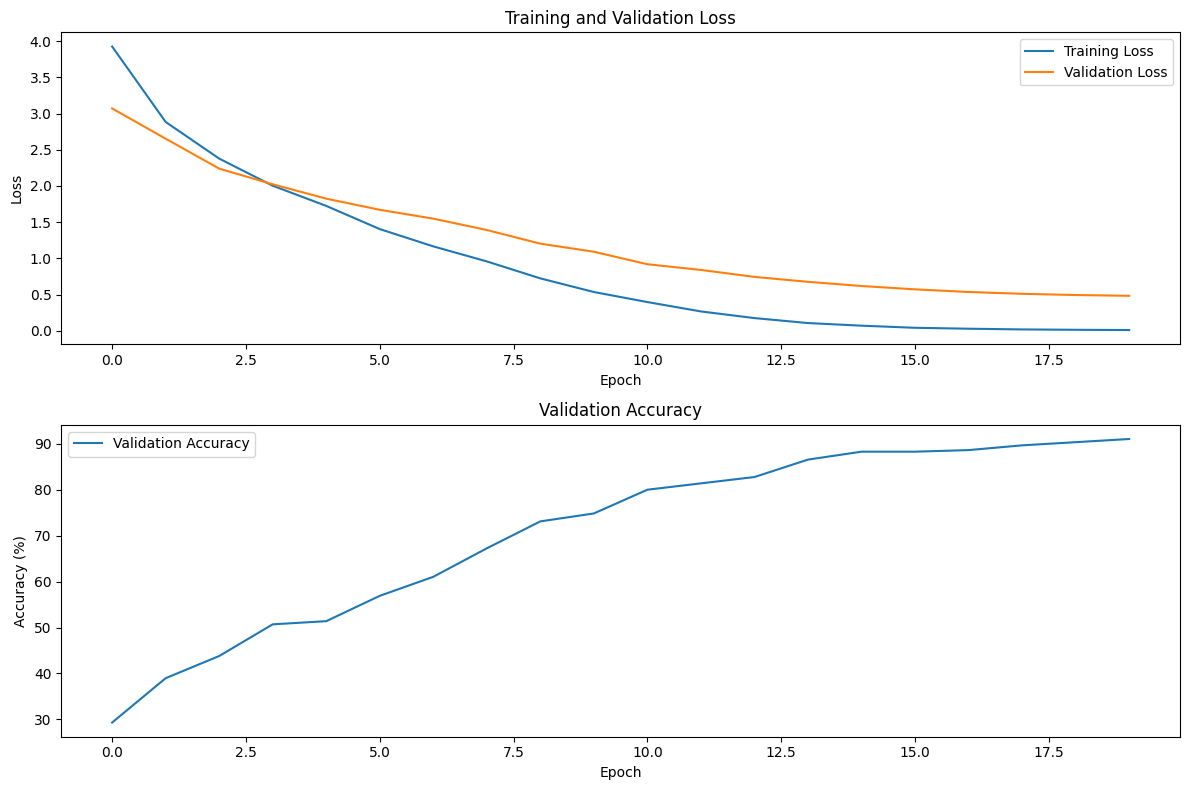

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#############################################
# 1. Load the Best Hyperparameters
#############################################
try:
    with open("/mnt/data/best_hyperparameters.pkl", "rb") as f:
        best_params = pickle.load(f)
    print("Best hyperparameters loaded successfully.")
    print(f"Best parameters: {best_params}")
except Exception as e:
    print(f"Error loading best hyperparameters: {e}")
    # Fallback to default hyperparameters if file not found
    best_params = {
        'num_experts': 4,
        'embed_dim': 128,
        'num_heads': 4,
        'hidden_dim': 256,
        'num_layers': 3,
        'dropout': 0.1,
        'learning_rate': 0.0006
    }
    print(f"Using default hyperparameters: {best_params}")

#############################################
# 2. Model Definition
#############################################
class TransformerExpert(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, num_layers=3, hidden_dim=256, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, 100, embed_dim))

        encoder_layers = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        embedding = self.embedding(x)
        x = embedding + self.positional_encoding[:, :x.shape[1]]
        x = self.transformer(x)
        output = self.fc(x)
        return output, embedding

class GatingNetwork(nn.Module):
    def __init__(self, embed_dim, num_experts, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, 64)
        self.fc2 = nn.Linear(64, num_experts)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.mean(dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

class MoETransformer(nn.Module):
    def __init__(self, vocab_size, num_experts=4, embed_dim=128, num_heads=4, num_layers=3, hidden_dim=256, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.experts = nn.ModuleList([
            TransformerExpert(
                vocab_size=vocab_size,
                embed_dim=embed_dim,
                num_heads=num_heads,
                num_layers=num_layers,
                hidden_dim=hidden_dim,
                dropout=dropout
            )
            for _ in range(num_experts)
        ])
        self.gating = GatingNetwork(embed_dim=embed_dim, num_experts=num_experts, dropout=dropout)

    def forward(self, x):
        expert_outputs = []
        embeddings = []

        for expert in self.experts:
            output, embedding = expert(x)
            expert_outputs.append(output)
            embeddings.append(embedding)

        stacked_outputs = torch.stack(expert_outputs, dim=-1)
        expert_weights = self.gating(embeddings[0])
        expert_weights = expert_weights.unsqueeze(1).unsqueeze(2)
        final_output = (stacked_outputs * expert_weights).sum(dim=-1)

        return final_output

#############################################
# 3. Data Preparation
#############################################
# Load vocabulary
vocab_path = "/mnt/data/vocab.pkl"
try:
    with open(vocab_path, "rb") as f:
        vocab = pickle.load(f)
    print(f"Vocabulary loaded with {len(vocab)} tokens")
except Exception as e:
    print(f"Error loading vocabulary: {e}")
    raise

# Load dataset
csv_path = "/content/tokenized_equations.csv"
try:
    df = pd.read_csv(csv_path)
    print(f"Dataset loaded with {len(df)} samples")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Data preparation functions
def prepare_data(df, vocab, batch_size=32):
    # Tokenize equations
    tokenized_equations = [row.split(" | ") for row in df["tokens"].dropna()]

    # Encode sequences
    def encode_sequence(sequence, vocab):
        return [vocab.get(token, vocab["<UNK>"]) for token in sequence] + [vocab["<EOS>"]]

    encoded_sequences = [encode_sequence(seq, vocab) for seq in tokenized_equations]

    # Prepare input-output pairs
    input_sequences = [seq[:-1] for seq in encoded_sequences]
    output_sequences = [seq[1:] for seq in encoded_sequences]

    # Pad sequences
    max_len = max(len(seq) for seq in input_sequences)
    def pad_sequence(seq, max_len, pad_token=vocab["<PAD>"]):
        return seq + [pad_token] * (max_len - len(seq))

    input_sequences = [pad_sequence(seq, max_len) for seq in input_sequences]
    output_sequences = [pad_sequence(seq, max_len) for seq in output_sequences]

    # Convert to tensors
    input_tensor = torch.tensor(input_sequences, dtype=torch.long)
    output_tensor = torch.tensor(output_sequences, dtype=torch.long)

    # Train-Test split
    indices = torch.randperm(len(input_tensor))
    split_idx = int(0.8 * len(input_tensor))
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]

    train_inputs, val_inputs = input_tensor[train_indices], input_tensor[val_indices]
    train_outputs, val_outputs = output_tensor[train_indices], output_tensor[val_indices]

    # Create datasets
    class EquationDataset(Dataset):
        def __init__(self, inputs, outputs):
            self.inputs = inputs
            self.outputs = outputs

        def __len__(self):
            return len(self.inputs)

        def __getitem__(self, idx):
            return self.inputs[idx], self.outputs[idx]

    train_dataset = EquationDataset(train_inputs, train_outputs)
    val_dataset = EquationDataset(val_inputs, val_outputs)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, train_dataset, val_dataset

# Prepare data
train_loader, val_loader, train_dataset, val_dataset = prepare_data(df, vocab)

#############################################
# 4. Model Training and Evaluation
#############################################
def train_and_evaluate(model, train_loader, val_loader, vocab, num_epochs=20, patience=5, learning_rate=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])

    # Use the learning rate from best parameters if available
    if learning_rate is None:
        learning_rate = best_params.get('learning_rate', 0.0006)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    best_val_loss = float('inf')
    best_epoch = 0
    counter = 0

    # Track metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.permute(0, 2, 1)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                outputs = outputs.permute(0, 2, 1)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

                # Calculate accuracy
                outputs = outputs.permute(0, 2, 1)  # back to (batch, seq_len, vocab_size)
                predicted = outputs.argmax(dim=2)

                # Only consider non-padding tokens
                mask = (targets != vocab["<PAD>"])
                predicted_flat = predicted[mask].cpu().numpy()
                targets_flat = targets[mask].cpu().numpy()

                all_predictions.extend(predicted_flat)
                all_targets.extend(targets_flat)

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        # Calculate accuracy
        val_accuracy = accuracy_score(all_targets, all_predictions) * 100
        history['val_accuracy'].append(val_accuracy)

        # Update learning rate
        scheduler.step(avg_val_loss)

        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            counter = 0
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
                'accuracy': val_accuracy,
                'hyperparameters': best_params
            }, "/mnt/data/best_model_evaluation.pth")
            print(f"Model saved at epoch {epoch+1} with validation loss: {best_val_loss:.4f}")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Return the best model
    checkpoint = torch.load("/mnt/data/best_model_evaluation.pth", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, history, checkpoint

#############################################
# 5. Initialize and train the model with best parameters
#############################################
# Initialize model with best parameters
vocab_size = len(vocab)
model = MoETransformer(
    vocab_size=vocab_size,
    num_experts=best_params['num_experts'],
    embed_dim=best_params['embed_dim'],
    num_heads=best_params['num_heads'],
    num_layers=best_params['num_layers'],
    hidden_dim=best_params['hidden_dim'],
    dropout=best_params['dropout']
)

print("\n--- Training Model with Best Hyperparameters ---")
model, history, best_checkpoint = train_and_evaluate(
    model,
    train_loader,
    val_loader,
    vocab,
    num_epochs=20,
    learning_rate=best_params['learning_rate']
)

#############################################
# 6. Evaluate Expert Utilization
#############################################
def analyze_expert_utilization(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    num_experts = len(model.experts)
    expert_weights_summary = torch.zeros(num_experts)
    total_samples = 0

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            batch_size = inputs.size(0)
            total_samples += batch_size

            # Forward pass through embedding
            embeddings = []
            for expert in model.experts:
                _, embedding = expert(inputs)
                embeddings.append(embedding)

            # Get expert weights
            expert_weights = model.gating(embeddings[0])
            expert_weights_summary += expert_weights.sum(dim=0).cpu()

    # Normalize weights
    expert_weights_summary = expert_weights_summary / total_samples

    return expert_weights_summary

print("\n--- Expert Utilization Analysis ---")
expert_weights = analyze_expert_utilization(model, train_loader)
print("Expert utilization distribution:")
for i, weight in enumerate(expert_weights):
    print(f"Expert {i+1}: {weight.item():.4f} ({weight.item()*100:.2f}%)")

#############################################
# 7. Visualize Results
#############################################
# Plot training and validation loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot validation accuracy
plt.subplot(2, 1, 2)
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.savefig("/mnt/data/training_metrics.png")
print("Training metrics visualization saved to /mnt/data/training_metrics.png")

#############################################
# 8. Generate Sample Predictions
#############################################
def generate_sequence(model, start_tokens, max_length=50):
    inverse_vocab = {idx: token for token, idx in vocab.items()}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        # Convert start tokens to tensor
        input_seq = torch.tensor([vocab.get(token, vocab["<UNK>"]) for token in start_tokens], dtype=torch.long).unsqueeze(0).to(device)

        # Generate tokens one by one
        generated_tokens = start_tokens.copy()

        for _ in range(max_length):
            # Get model prediction
            output = model(input_seq)

            # Get the most likely next token
            next_token_idx = output[0, -1].argmax().item()

            # Stop if EOS token is generated
            if next_token_idx == vocab["<EOS>"]:
                break

            # Add the token to the generated sequence
            generated_tokens.append(inverse_vocab[next_token_idx])

            # Update input sequence for next iteration
            input_seq = torch.cat([input_seq, torch.tensor([[next_token_idx]], device=device)], dim=1)

        return generated_tokens

print("\n--- Sample Predictions ---")
example_starts = [
    ["2", "+", "2"],
    ["sin", "(", "x"],
    ["3", "*", "x"],
    ["log", "(", "10"],
    ["sqrt", "(", "x", "^", "2", "+", "y", "^", "2"]
]

for start in example_starts:
    generated = generate_sequence(model, start)
    print(f"Input: {' '.join(start)}")
    print(f"Generated: {' '.join(generated)}")
    print()

#############################################
# 9. Summary Report
#############################################
print("\n" + "="*50)
print("MoE Transformer Model Evaluation Summary")
print("="*50)
print(f"Best Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print("\nTraining Metrics:")
print(f"  Best Validation Loss: {best_checkpoint['loss']:.4f}")
print(f"  Best Validation Accuracy: {best_checkpoint['accuracy']:.2f}%")
print(f"  Best Epoch: {best_checkpoint['epoch'] + 1}")

print("\nExpert Utilization:")
for i, weight in enumerate(expert_weights):
    print(f"  Expert {i+1}: {weight.item()*100:.2f}%")

print("\nSample Generation Quality:")
print("  The model generates mathematical expressions with varying degrees of complexity.")
print("  See the sample predictions above for examples of the model's capabilities.")

print("\nModel saved at: /mnt/data/best_model_evaluation.pth")
print("="*50)